In [1]:
import sys, os, glob
import matplotlib.pyplot as plt
import numpy as np
import torch

import models.rdmpy.blur as blur
import models.rdmpy.calibrate as calibrate

import models.forward as forward
import data_utils.dataset as ds
import data_utils.preprocess_data as prep_data
import utils.psf_calibration_utils as psf_utils
import utils.diffuser_utils as diffuser_utils
import utils.helper_functions as helper

device = "cuda:0"
%load_ext autoreload
%autoreload 2

## PSF calibration
To perform spatially varying deconvolution, we need spatially varying PSFs. We can generate PSFs for every point in the system by estimating the seidel coefficients of the lens, and generating PSF data for each point based off of these coefficients.

We will use the `rdmpy.calibrate.calibrate()` method to estimate coefficients based off of our superimposed psf measurements.

### Calculating the alignment axis
To estimate the alignment axis, we note that field curvature in the system induces barrel distortion sampled as we translate our sensor through the image plane. The result is radial translation of the center of our PSF at different levels of focus. We can leverage this translation to estimate the alignment axis. For more information see [psf_calibration_utils.py](./utils/psf_calibration_utils.py).

Notice that a cluster will form near the estimate. A "good" estimate is one with a clustered distribution. Consider using different estimation and coordinate localizing methods, or changing which two focus levels you are comparing.

Reading psf:   0%|          | 0/48 [00:00<?, ?it/s]

Reading psf: 100%|██████████| 48/48 [00:01<00:00, 34.49it/s]


Found 48 psf measurements.
Get centers: 100%|██████████| 48/48 [00:03<00:00, 12.90it/s]
Estimated center: [880 421]


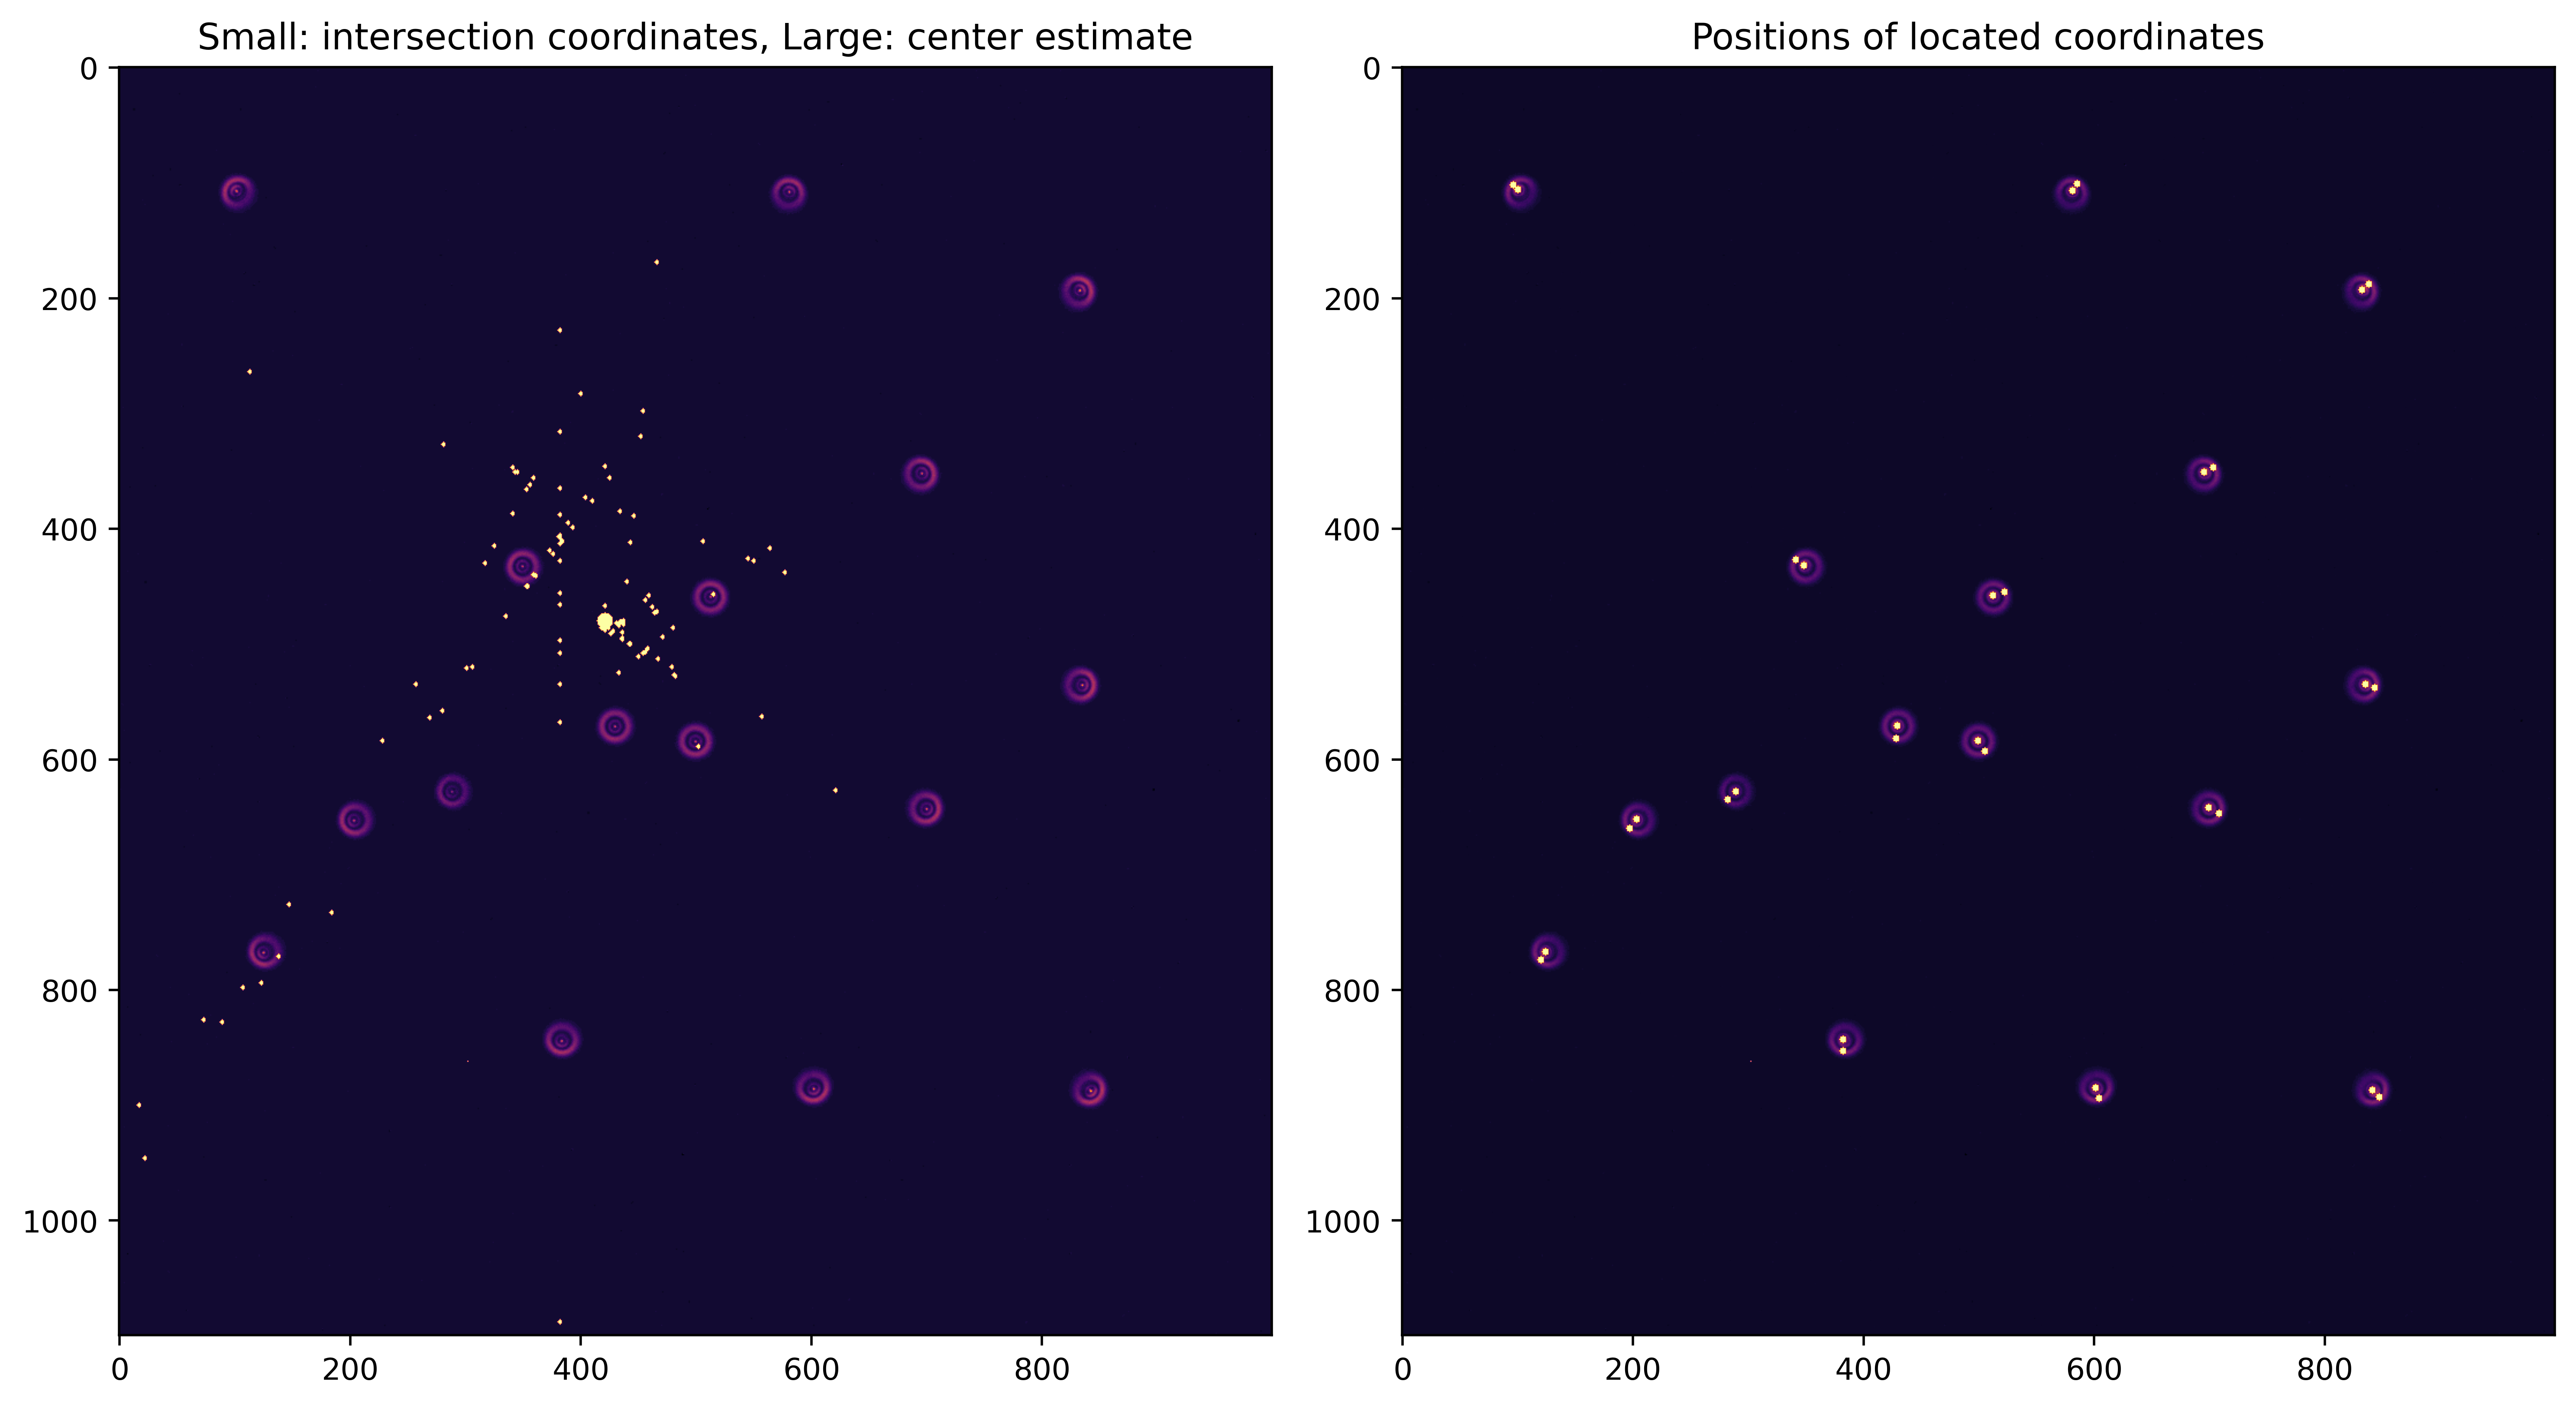

In [2]:
psf_path = "../defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/10_26/multipos/alignment_psfs_telecent25um_10_26"

focus_levels = 3 # levels of focus in your measurements
estimate_method = "median" # mean if your points seem to shift very consistently, median if they dont
coord_method = "conv" # method for estimating psf coordinates. Note "conv" may outperform but is slower
crop = (400,0,1500,1000) # crop down to the general psf location to reduce computation
anchor_idx = 1 # index of first focus to draw vector from
delta_idx = 2 # index of second focus to draw vector through
conv_kern_sizes = [7, 15, 21] # approximate psf sizes, used as kernel size in convolution

# Note: a "good" estimate is one with a clustered distribution
alignment_estimate = psf_utils.estimate_alignment_center(
    psf_path, 
    focus_levels,
    estimate_method=estimate_method, 
    coord_method=coord_method, 
    anchor_foc_idx=anchor_idx,
    vector_foc_idx=delta_idx,
    crop = crop,
    verbose=True,
    plot=True
)

### Calibration
Now that we have our alignment axis, we can crop our image around the axis and perform seidel coefficient estimation. Note that it is important that crops either fully include or disclude PSFs. Half-cropped PSFs will through off the optimization.

In [3]:
true_size = (768, 768)
patch_size = (768, 768)
crop = (
    alignment_estimate[0] - true_size[0]//2,
    alignment_estimate[1] - true_size[1]//2,
    alignment_estimate[0] + true_size[0]//2,
    alignment_estimate[1] + true_size[1]//2
)

psfs = psf_utils.read_psfs(psf_path, crop = crop, patchsize=patch_size)
supimp_psfs = psf_utils.superimpose_psfs(psfs, focus_levels = focus_levels, one_norm = True)

Reading psf:   0%|          | 0/48 [00:00<?, ?it/s]

Reading psf: 100%|██████████| 48/48 [00:01<00:00, 43.12it/s]


To create multiple focus-level psf data, you will need to run these next cells multiple times

  0%|          | 0/300 [00:00<?, ?it/s]

fitting seidel coefficients...


100%|██████████| 300/300 [02:28<00:00,  2.02it/s]


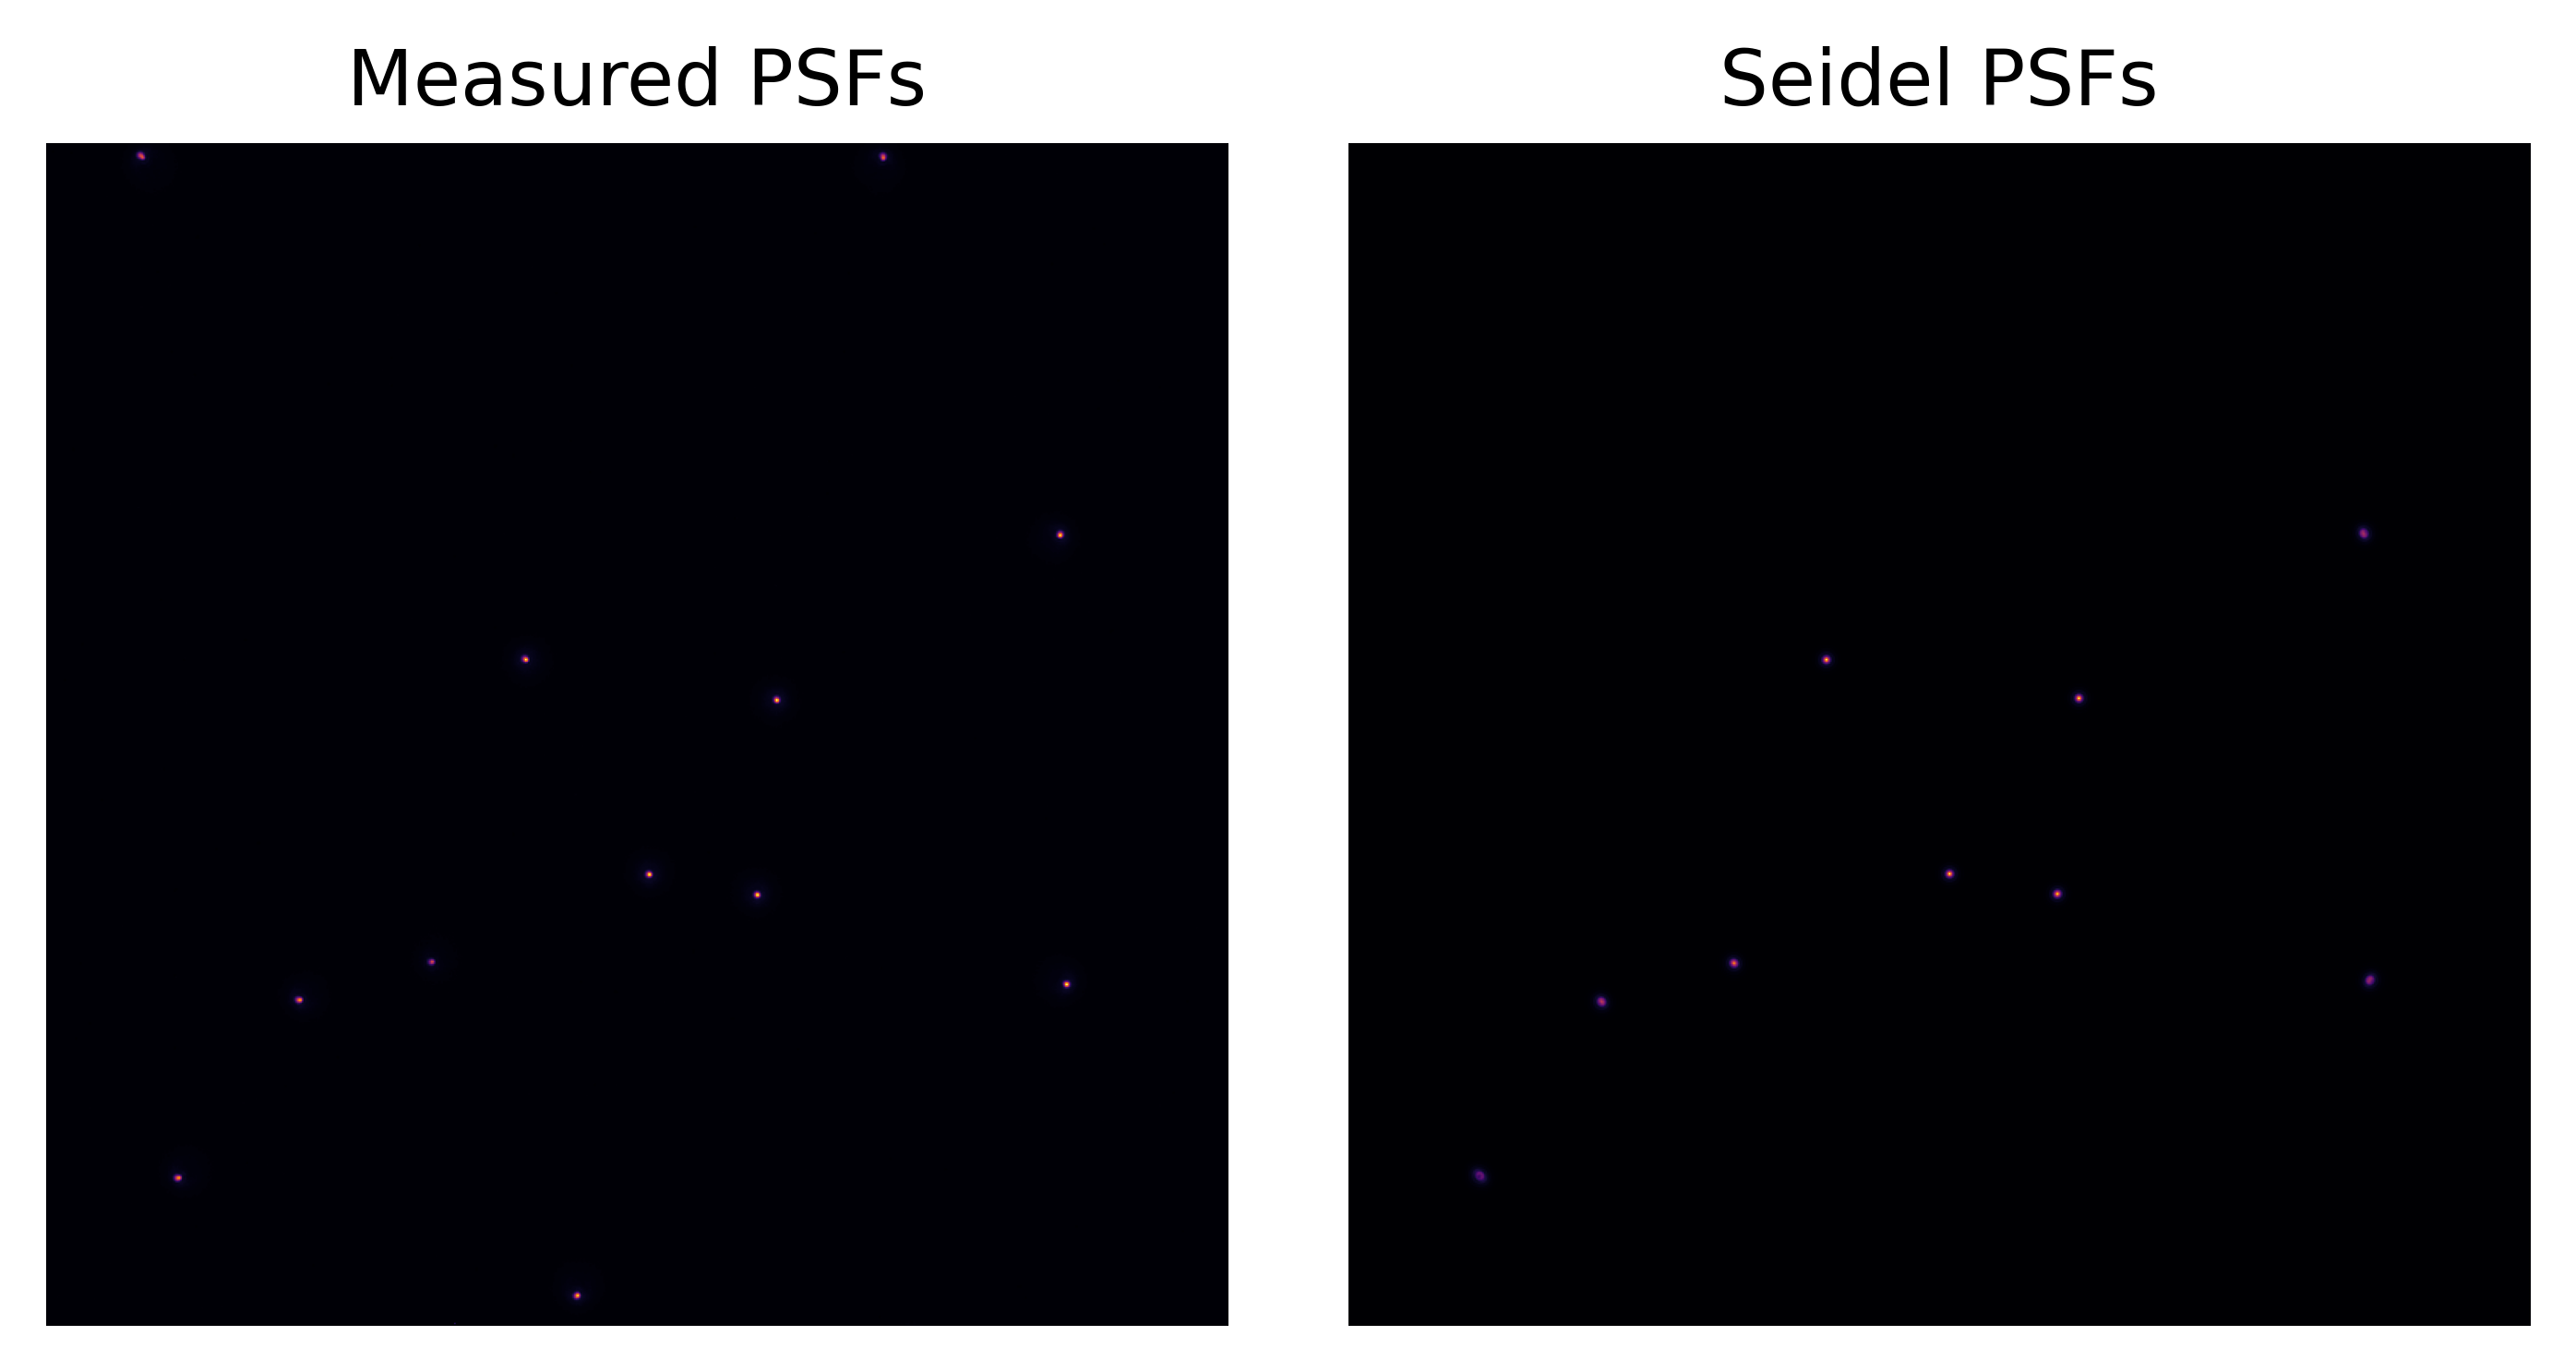

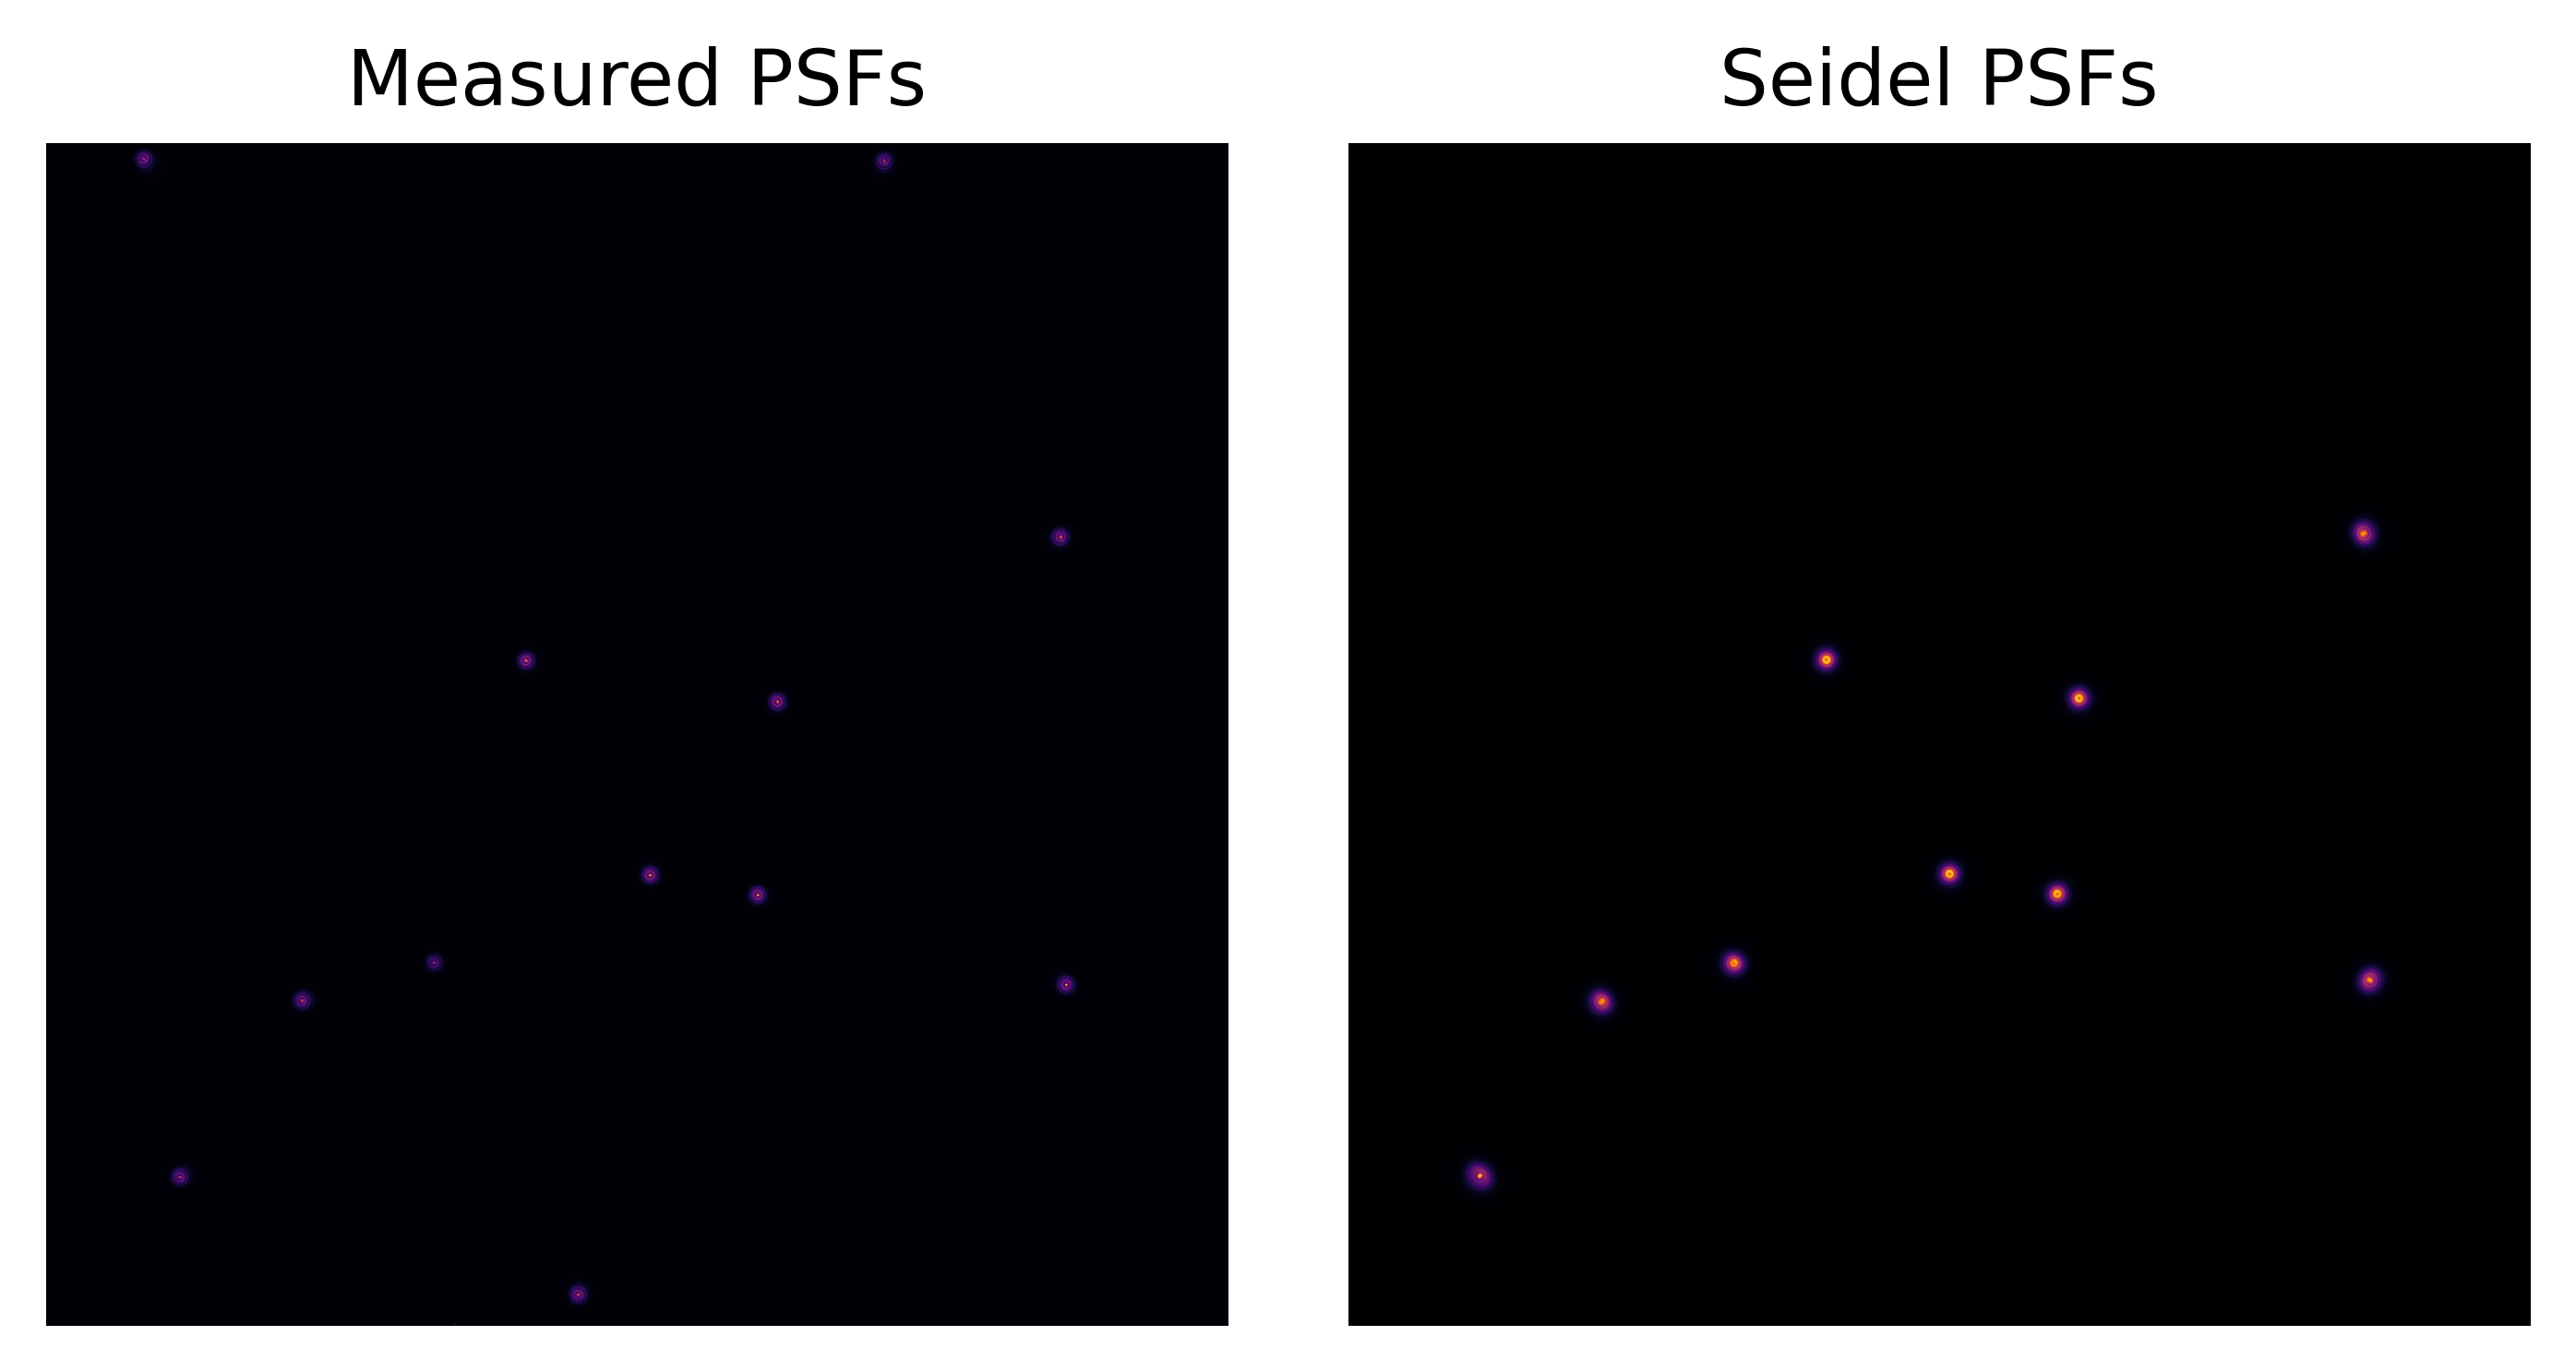

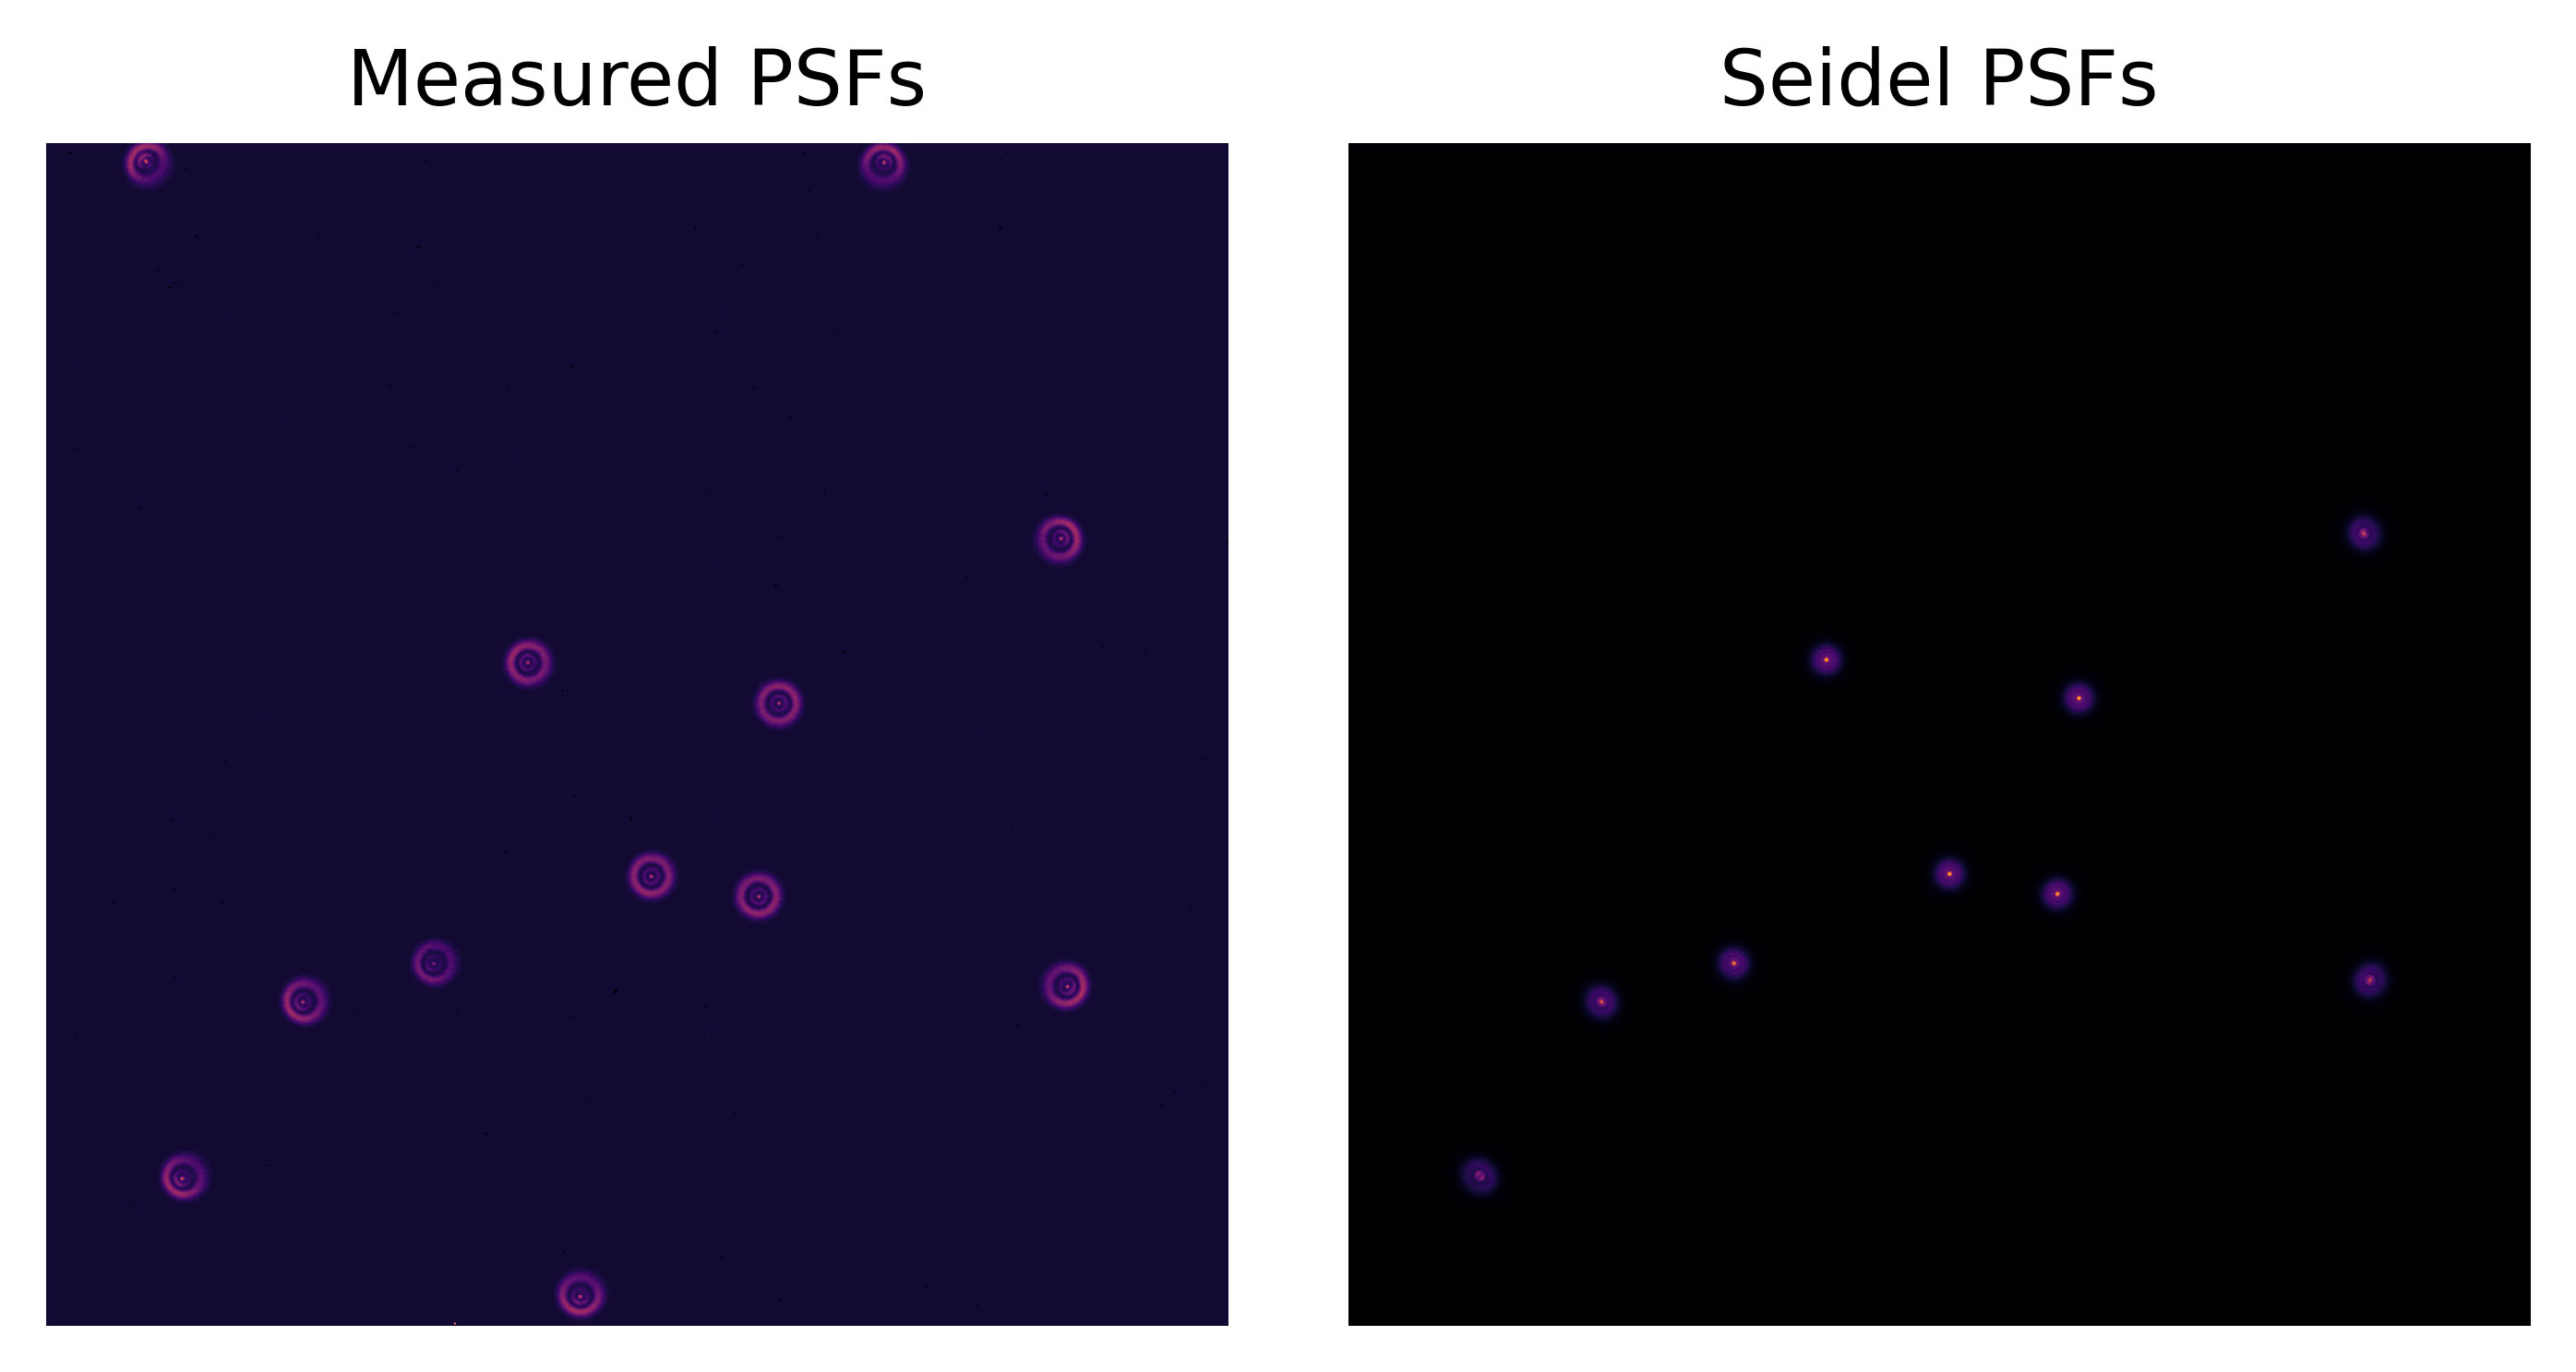

Fitted seidel coefficients: tensor([[[ 0.5649],
         [-0.0659],
         [-0.1590],
         [ 0.3358],
         [ 0.0053],
         [ 0.0000]],

        [[ 0.5649],
         [-0.0659],
         [-0.1590],
         [ 0.3358],
         [ 0.0053],
         [ 0.4500]],

        [[ 0.5649],
         [-0.0659],
         [-0.1590],
         [ 0.3358],
         [ 0.0053],
         [ 0.9000]]])


In [7]:
dim = patch_size[0] # cropsize of calibration image

num_seidel = 5 # number of seidel coefficients to fit: 5 to disclude defocus, 6 to include defocus
calibrate_focus_level = 2 # focus level to run calibration on
fit_params = {
    "threshold": 0.4,   # proportion of max val for psf localization, lower = more sensitive
    "min_distance": 30,      # min distance between psfs in your image
    "threshold_quantile": 0.6, # quantile value (0-1) for actual thresholding of calib image
    "iters": 300,
    "enforce_anchor_blur": 0.45, # blur level to enforce (if known), requires num_seidel=5
    "anchor_blur_idx": 1,
    "seidel_init": [[ 0.3847],[0.4182],[-0.0084],[ 0.0743],[-0.0491]]
} 


seidel_coeffs = calibrate.calibrate_stack(
    np.stack(supimp_psfs, 0), 
    dim=dim,
    device=device,
    show_psfs=True,
    fit_params=fit_params,
    get_psf_data=False
)

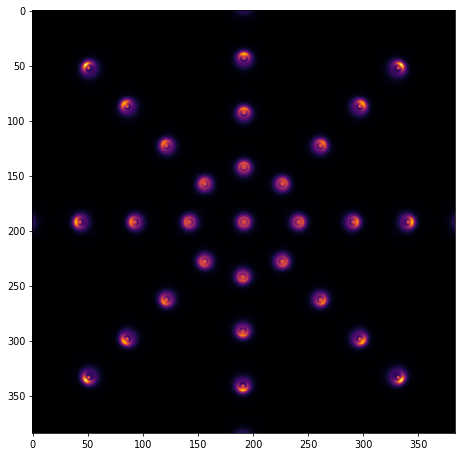

In [195]:
seidel_coeffs = torch.tensor([[ 0.3847],
         [0.4182],
         [-0.0084],
         [ 0.0743],
         [-0.0491],
         [ 0.8000]], device=device)

img = psf_utils.view_coef_psfs(seidel_coeffs, device=device, dim=384)
plt.figure(figsize=(8,8), dpi=70)
plt.imshow(img, cmap = "inferno")

In [196]:
psf_data = calibrate.get_psfs(seidel_coeffs, dim=384, model="lri", verbose=True, device=device)
psf_utils.save_lri_psf(seidel_coeffs, psf_data, os.path.join(psf_path, "dim384_3focus"), 2)

  0%|          | 0/384 [00:00<?, ?it/s]

rendering PSFs...


100%|██████████| 384/384 [00:13<00:00, 27.82it/s]


This calibration is slow and expensive, and as a result we will save the calibration psf data after running it once. Once you're happy with the hyperparameters selecting the psf data above, run the following cell to save it. 

Note: this may take a while, as the calibration data is *very* large.

In [6]:
psf_utils.save_lri_psf(seidel_coeffs, psf_data, psf_path, calibrate_focus_level)

Saved psf data of shape (768, 769, 768) to ../defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/10_26/multipos/alignment_psfs_telecent25um_10_26/lri_psf_calib_1.mat.


## Image transformation: simulating spatially varying convolution
Our typical [forward model](./models/forward.py) approximates a linear spatially invariant (LSI) system by performing a standard convolution with the input at each level of defocus. 

As an initial reconstruction step, we consider the adjoint of our system. Our LSI forward model is:

$$\mathbf b_i = \sum_{\lambda=0}^{K-1} \mathbf M_{\lambda}[x,y] \cdot  \text{crop} \Big( \mathbf h_i[x,y,\lambda] \stackrel{[x,y]}{*} \mathbf v[x,y,\lambda] \Big) = \mathbf A_i \mathbf v$$

and the adjoint is found as:

$$ \hat{\mathbf{v}}_i = \mathbf{h}_i^* \stackrel{[x,y]}{*} \text{pad}(\mathbf{M}_\lambda [x,y] \cdot \mathbf{b}_i) = \mathbf{A}_i^H\mathbf b_i$$

For an LRI system, the assumption changes, and we must now perform a LRI convolution (denoted here as $\odot$) between our spatially varying psf data $\tilde{\mathbf h}$ and our image:

$$\mathbf b_i = \sum_{\lambda=0}^{K-1} \mathbf M_{\lambda}[x,y] \cdot  \text{crop} \Big( \tilde{\mathbf h_i}[\rho,\theta] \stackrel{[\rho, \theta]}\odot \mathbf v[\rho,\theta,\lambda] \Big) = \tilde{\mathbf A_i} \mathbf v$$

Where $i$ denotes the focus level. But, given that the spatially varying convolution with a spatially varying $\tilde{\mathbf h}$ can, like a uniform convolution with a LSI $\mathbf h$, be written as matrix operations $\tilde{\mathbf A}$ and $\mathbf A$ (respectively), the adjoint of this system is also found as:

$$ \hat{\mathbf v_i} = \tilde{\mathbf h_i}^* \stackrel{[\rho,\theta]} \odot \text{pad}(\mathbf{M}_\lambda [x,y] \cdot \mathbf{b}_i) = \tilde{\mathbf A_i}^H\mathbf b_i$$


### Data preprocessing
First we must preprocess our data into a usable form. We use three datasets - [Harvards hyperspectral dataset](http://vision.seas.harvard.edu/hyperspec/), [Pavia Centre and University](https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes), and the [Geissen Fruit Dataset](https://zenodo.org/record/2611806).

Note that this may take a while, as some of the data is quite large.

In [4]:
raw_datapath = "/home/cfoley_waller/10tb_extension/defocam/defocuscamdata/sample_data/"
processed_datapath = "/home/cfoley_waller/defocam/defocuscamdata/sample_data_preprocessed_lri_11_2"

patchsize = (256, 256) # size of patches to chunk data - factor of cropsize for best results
num_channels = 30 # channels are linearly interpolated to fit this value from raw data - note same issue as above
prep_data.preprocess_harvard_data(os.path.join(raw_datapath, "harvard"), os.path.join(processed_datapath, "harvard_data"), patchsize, num_channels)
prep_data.preprocess_pavia_data(os.path.join(raw_datapath, "paviadata"), os.path.join(processed_datapath, "pavia_data"), patchsize, num_channels)
prep_data.preprocess_fruit_data(os.path.join(raw_datapath, "fruitdata/pca"), os.path.join(processed_datapath, "fruit_data"), patchsize, num_channels)

Preprocessing Pavia Data: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]


### Performing the forward and adjoint computations
Next we initialize our forward model, which uses our calibrated PSF data to perform a linear revolution-invariant (LRI) spatially varying convolution using the `rdmpy.blur.ring_convolve()` function via ring-convolution. This is incorperated into the `Hfor_varying()` and `Hadj_varying()` methods of our [forward model](models/forward.py).

In [28]:
config_path = "/home/cfoley_waller/defocam/SpectralDefocusCam/config_files/training/train_11_4_2023_lri_precomputed_stack3.yml"
config = helper.read_config(config_path)

mask = diffuser_utils.load_mask(
    path=config["mask_dir"],
    patch_crop_center=config["image_center"],
    patch_crop_size=config["patch_crop"],
    patch_size=config["patch_size"],
)
forward_model = forward.ForwardModel(mask, config["forward_model_params"], config["psf_dir"], device=device)

# The following should show whether we are using a varying or invariant Hfor and Hadj
print(forward_model.fwd, forward_model.adj)

<bound method ForwardModel.Hfor_varying of ForwardModel()> <bound method ForwardModel.Hadj_varying of ForwardModel()>


We can now use our forward model to build supervised learning pairs for each of our data samples. Doing this statically should drastically reduce training time, as the computation necessary to simulate our data is only done *once*, here.

**Note**: each simulated measurement stack is stored with the ground truth patch in its `.mat` file under a key defined by our forward model's params.

In [32]:
forward.build_data_pairs(os.path.join(config["base_data_path"], "harvard_data"), forward_model)
forward.build_data_pairs(os.path.join(config["base_data_path"], "pavia_data"), forward_model)
forward.build_data_pairs(os.path.join(config["base_data_path"], "fruit_data"), forward_model)

Generating Pair harvard_data:   0%|          | 0/666 [00:00<?, ?it/s]

Generating Pair fruit_data: 100%|██████████| 38/38 [06:29<00:00, 10.26s/it]


: 

Just to get an idea of what we were doing doing, we can look at the models output from the last step.

torch.Size([2, 384, 769, 384])


TypeError: Image data of dtype complex64 cannot be converted to float

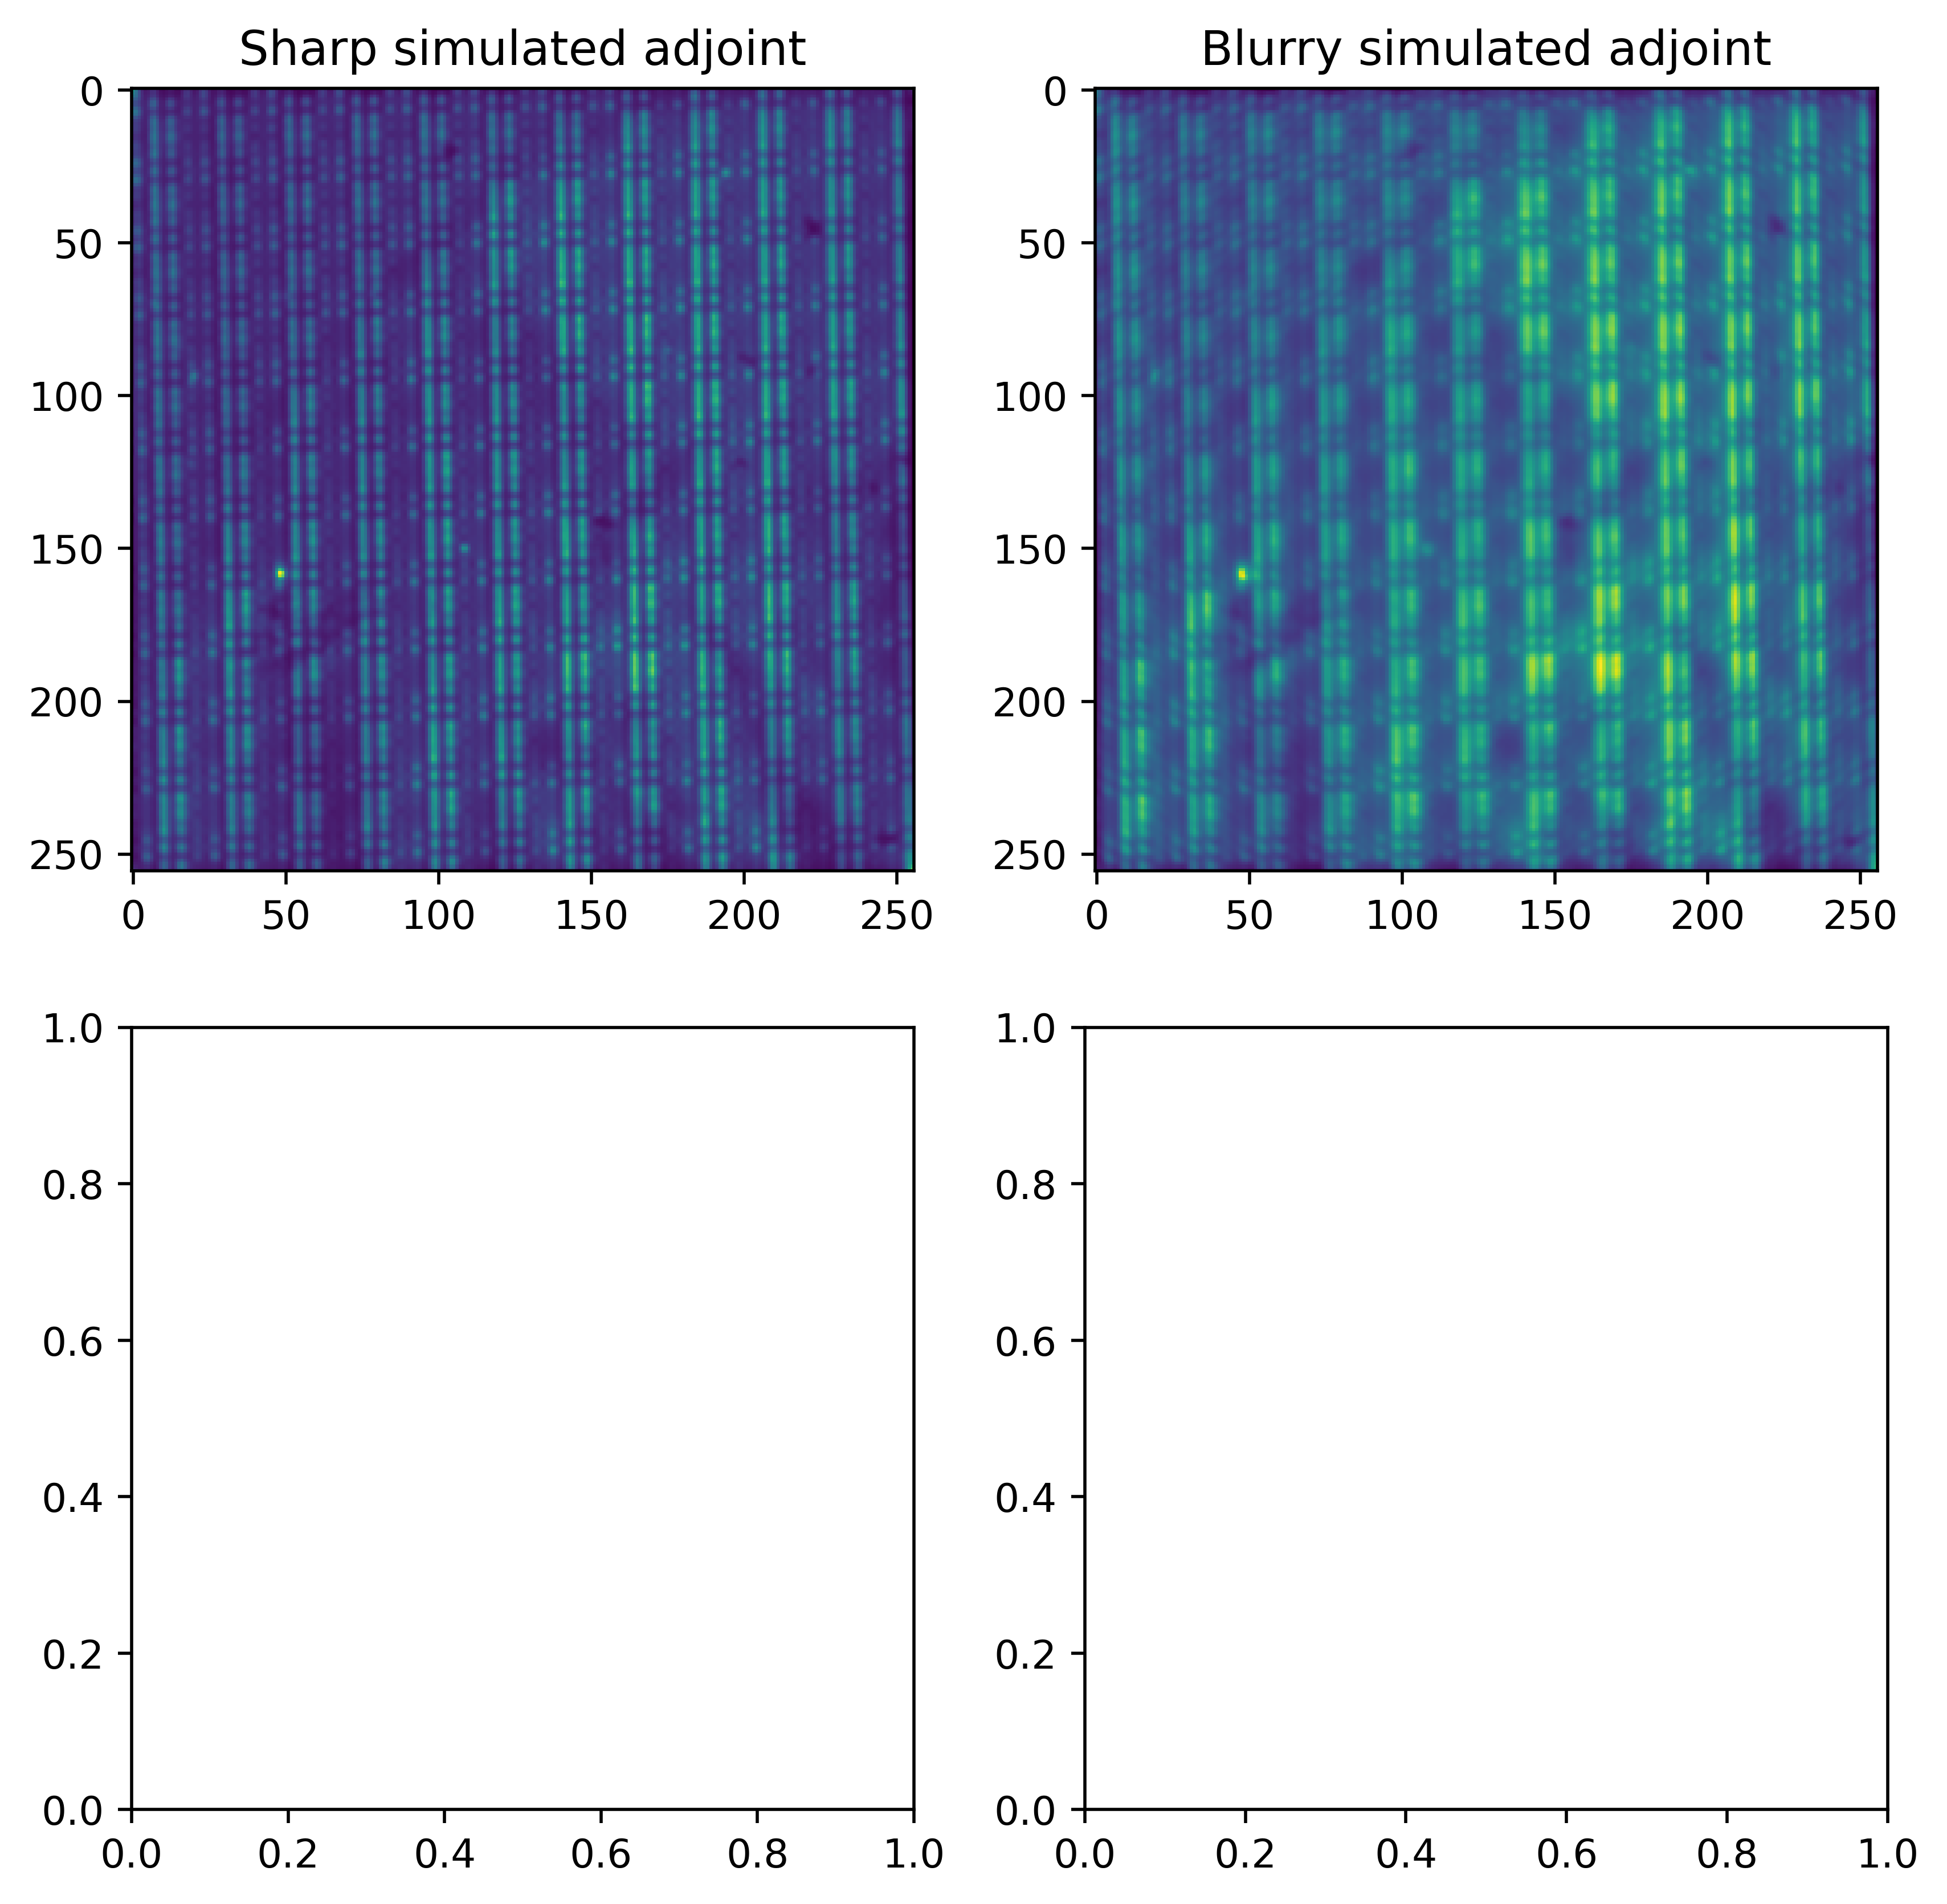

In [21]:
output, psf_data = forward_model.b, forward_model.psfs
print(psf_data.shape)
fig, ax = plt.subplots(2,2, figsize = (8,8))
ax[0,0].imshow(np.mean(output.detach().cpu().numpy()[0,0], 0))
ax[0,0].set_title("Sharp simulated adjoint")
ax[0,1].imshow(np.mean(output.detach().cpu().numpy()[0,1], 0))
ax[0,1].set_title("Blurry simulated adjoint")
ax[1,0].imshow(np.mean(psf_data.detach().cpu().numpy()[0], 1))
ax[1,0].set_title("Sharp LRI psf")
ax[1,1].imshow(np.mean(psf_data.detach().cpu().numpy()[1], 1))
ax[1,1].set_title("Blurry LRI psf")
plt.tight_layout()
plt.show()

And we're done. You should now be able to use these data pairs to train a deep reconstruction model.